# Eval the results of FLAN UL2

In [3]:
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import f1_score, precision_score, recall_score, \
    accuracy_score

import re
from typing import List, Tuple

import pandas as pd


def is_contained(inner_start, inner_end, outer_start, outer_end):
    return (
        outer_start <= inner_start <= outer_end
        and outer_start <= inner_end <= outer_end
        and (inner_start, inner_end) != (outer_start, outer_end)
    )


def find_all_occurrences_indices(
    sentence: str,
    label: str,
) -> List[Tuple[int, int]]:
    """
    Finds all occurrences of a label in a sentence and returns a list of tuples
    with the start and end indices of the occurrences.

    Args:
        sentence: The sentence to search in.
        label: The label to search for.

    Returns:
        A list of tuples with the start and end indices of the occurrences.
    """
    return [
        (int(match.start()), int(match.end()))
        for match in re.finditer(label, sentence)
    ]


def find_contained_labels(labels):
    """
    Finds all labels that are contained in other labels.

    Args:
        labels: A list of labels.

    Returns:
        A dictionary with the labels as keys and a list of labels that are
        contained in the key label as values.
    """
    return {
        label_1: [
            label2
            for label2 in labels
            if label_1 in label2 and label_1 != label2
        ]
        for label_1 in labels
    }


def find_labels_in_sentence(
    sentence: str,
    labels: List[str],
) -> List[List[Tuple[int, int]]]:
    """
    Finds all occurrences of the labels in a sentence and returns a list of
    lists with the occurrences of each label.

    Labels that are contained in other labels are not returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.

    Returns:
        A list of lists with the positional occurrence of each label.
    """
    if not labels:
        return []

    containable_map = find_contained_labels(labels)
    sentence_lower = sentence.lower()
    occurrences = [
        find_all_occurrences_indices(sentence_lower, label.lower())
        for label in labels
    ]
    label_occurrences = dict(zip(labels, occurrences))
    included_list = []
    for label, inner_pos in zip(labels, occurrences):
        contained = set()
        containing_labels = containable_map.get(label, set())

        for bigger_label in containing_labels:
            locations: List[Tuple[int, int]] = label_occurrences.get(
                bigger_label,
                list(),
            )

            for inner_start, inner_end in inner_pos:
                for outer_start, outer_end in locations:
                    if is_contained(
                        inner_start,
                        inner_end,
                        outer_start,
                        outer_end,
                    ):
                        contained.add((inner_start, inner_end))
        included_list.append(list(contained))

    return [
        list(set(pos) - set(included))
        for pos, included in zip(occurrences, included_list)
    ]


def find_label(
    sentence: str,
    labels: List[str],
    default_label: str = "?",
) -> str:
    """
    Search for given labels in the sentence and returns it if found. If only
    one label occur in the sentence, it will be returned. If no label or
    different labels occur in the sentence, '?' is returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.
        default_label: The label to return if no label or different labels
            occur in the sentence.

    Returns:
        The label that occurs in the sentence or '?' if no label occurs in the
        sentence.
    """
    occurrences = find_labels_in_sentence(sentence=sentence, labels=labels)
    non_empty_indices = [i for i, sublist in enumerate(occurrences) if sublist]
    return (
        labels[non_empty_indices[0]]
        if len(
            non_empty_indices,
        )
           == 1
        else default_label
    )


def _soft_parse(
    df: pd.DataFrame,
    in_col: str,
    parsed_col: str,
    labels: List[str] = None,
) -> pd.DataFrame:
    if labels is None:
        raise ValueError("Labels are not set!")

    df[parsed_col] = df[in_col].apply(
        lambda x: find_label(x, labels),
    )


In [1]:

# load
model = 'flan-ul2'

# load results
zero_shot = pd.read_csv(f"../zero-shot/data/{model}.csv")
zero_shot_with_system = pd.read_csv(
    f"../zero-shot-system_prompt/data/{model}.csv")
zero_shot_cot = pd.read_csv(f"../zero-shot-cot/data/{model}.csv")
two_shot = pd.read_csv(f"../2-shot/data/{model}.csv")
four_shot = pd.read_csv(f"../4-shot/data/{model}.csv")
eight_shot = pd.read_csv(f"../8-shot/data/{model}.csv")

two_shot_cot = pd.read_csv(f"../2-shot-CoT/data/{model}.csv")
four_shot_cot = pd.read_csv(f"../4-shot-CoT/data/{model}.csv")
eight_shot_cot = pd.read_csv(f"../8-shot-CoT/data/{model}.csv")

#load pool
pool = load_dataset('mediabiasgroup/BABE-icl-pool')['train'].to_pandas()

# exclude pool from model (if needed)
zero_shot = zero_shot.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
zero_shot_with_system = zero_shot_with_system.merge(pool['text'], on='text',
                                                    how='left',
                                                    indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
zero_shot_cot = zero_shot_cot.merge(pool['text'], on='text', how='left',
                                    indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
two_shot = two_shot.merge(pool['text'], on='text', how='left',
                          indicator=True).query('_merge == "left_only"').drop(
    '_merge', axis=1)
four_shot = four_shot.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
eight_shot = eight_shot.merge(pool['text'], on='text', how='left',
                              indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
two_shot_cot = two_shot_cot.merge(pool['text'], on='text', how='left',
                              indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
four_shot_cot = four_shot_cot.merge(pool['text'], on='text', how='left',
                              indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
eight_shot_cot = eight_shot_cot.merge(pool['text'], on='text', how='left',
                              indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)


#load babe
dataset = load_dataset('mediabiasgroup/BABE-v4')
df_babe = pd.DataFrame(dataset['train'])

# df_merge = babe at begin
df_merge_all_runs = df_babe
df_merge_all_runs_with_errors = df_babe

NameError: name 'pd' is not defined

# Zero shot

In [5]:
_soft_parse(zero_shot, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
zero_shot.query("label == '?'")

,text,response,raw_data,query,label


In [6]:
zero_shot = zero_shot.rename(columns={"label": "0_shot_label"})
zero_shot['0_shot_label'] = zero_shot['0_shot_label'].replace('BIASED', 1)
zero_shot['0_shot_label'] = zero_shot['0_shot_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(zero_shot[zero_shot['0_shot_label'] != '?'][['text', '0_shot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(zero_shot[zero_shot['0_shot_label'] != '?'][['text', '0_shot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(zero_shot[['text', '0_shot_label']], on='text')


ground_truth = df_merge['label']
zero_shot_label = df_merge['0_shot_label']

In [7]:
print("F1-Score with Flan Ul2: ", f1_score(ground_truth, zero_shot_label))
print("Precision with Flan Ul2: ",
      precision_score(ground_truth, zero_shot_label))
print("Recall with Flan Ul2: ",
      recall_score(ground_truth, zero_shot_label))
print("Accuracy with Flan Ul2: ",
      accuracy_score(ground_truth, zero_shot_label))

F1-Score with Flan Ul2:  0.7186726102030709
Precision with Flan Ul2:  0.7088422081094284
Recall with Flan Ul2:  0.7287795077850326
Accuracy with Flan Ul2:  0.7174832131310619


# zero shot with system prompt

In [8]:
zero_shot_with_system.query("label == '?'")

,text,response,raw_data,query,label


In [9]:
zero_shot_with_system = zero_shot_with_system.rename(
    columns={"label": "0_shot_with_system_label"})
zero_shot_with_system['0_shot_with_system_label'] = zero_shot_with_system[
    '0_shot_with_system_label'].replace('BIASED', 1)
zero_shot_with_system['0_shot_with_system_label'] = zero_shot_with_system[
    '0_shot_with_system_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(zero_shot_with_system[zero_shot_with_system['0_shot_with_system_label'] != '?'][['text', '0_shot_with_system_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(zero_shot_with_system[zero_shot_with_system['0_shot_with_system_label'] != '?'][['text', '0_shot_with_system_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(zero_shot_with_system[['text', '0_shot_with_system_label']], on='text')

ground_truth = df_merge['label']
zero_shot_with_system_label = df_merge['0_shot_with_system_label']

In [10]:
print("F1-Score with Flan Ul2 with System Prompt: ",
      f1_score(ground_truth, zero_shot_with_system_label))
print("Precision with Flan Ul2 with System Prompt: ",
      precision_score(ground_truth, zero_shot_with_system_label))
print("Recall with Flan Ul2 with System Prompt: ",
      recall_score(ground_truth, zero_shot_with_system_label))
print("Accuracy with Flan Ul2 with System Prompt: ",
      accuracy_score(ground_truth, zero_shot_with_system_label))

F1-Score with Flan Ul2 with System Prompt:  0.7203867848509267
Precision with Flan Ul2 with System Prompt:  0.7742494226327945
Recall with Flan Ul2 with System Prompt:  0.6735308890005023
Accuracy with Flan Ul2 with System Prompt:  0.7411091768216862


# zero shot CoT

In [11]:
zero_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
257,Big Ten Commissioner Jim Delany told The Athle...,Not biased because it is just reporting what w...,Not biased because it is just reporting what w...,You are an expert in media bias.\n\nInstructio...,?
591,He looks to quickly put his stamp on the court...,BIASED The sentence is biased because it is de...,BIASED The sentence is biased because it is de...,You are an expert in media bias.\n\nInstructio...,?
926,The votes come as a new conservative majority ...,BIASED Because the sentence is talking about a...,BIASED Because the sentence is talking about a...,You are an expert in media bias.\n\nInstructio...,?
1462,Hawley said he had asked Shogan to provide her...,Not Biased because it is true and not a biased...,Not Biased because it is true and not a biased...,You are an expert in media bias.\n\nInstructio...,?
1598,During her acceptance speech for best actress ...,Not biased. Williams went on a bizarre rant ab...,Not biased. Williams went on a bizarre rant ab...,You are an expert in media bias.\n\nInstructio...,?
1745,"In response to the hacking, the United States ...","BIASED Because the sentence is true, it is not...","BIASED Because the sentence is true, it is not...",You are an expert in media bias.\n\nInstructio...,?
1960,Two police officers have been arrested for all...,Not biased because it is a true story. The Geo...,Not biased because it is a true story. The Geo...,You are an expert in media bias.\n\nInstructio...,?
2126,"Nevertheless, The Jesus Is King crooner launch...",Not biased because it is not a biased opinion....,Not biased because it is not a biased opinion....,You are an expert in media bias.\n\nInstructio...,?
2129,"In addition to the 10 people who were killed, ...",BIASED Because the sentence only mentions the ...,BIASED Because the sentence only mentions the ...,You are an expert in media bias.\n\nInstructio...,?
2137,The Sandy Hook tragedy rocked the United State...,BIASED Because the sentence is about a tragedy...,BIASED Because the sentence is about a tragedy...,You are an expert in media bias.\n\nInstructio...,?


In [12]:
def update_label(row):
    if row['response'].startswith("Not biased") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("Not Biased") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("BIASED") and row['label'] == '?':
        return 'BIASED'
    else:
        return row['label']


zero_shot_cot['label'] = zero_shot_cot.apply(update_label, axis=1)
zero_shot_cot.query("label == '?'")

,text,response,raw_data,query,label


In [13]:
zero_shot_cot = zero_shot_cot.rename(columns={"label": "0_shot_cot_label"})
zero_shot_cot['0_shot_cot_label'] = zero_shot_cot['0_shot_cot_label'].replace(
    'BIASED', 1)
zero_shot_cot['0_shot_cot_label'] = zero_shot_cot['0_shot_cot_label'].replace(
    'NOT BIASED', 0)

df_merge = df_babe.merge(zero_shot_cot[zero_shot_cot['0_shot_cot_label'] != '?'][['text', '0_shot_cot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(zero_shot_cot[zero_shot_cot['0_shot_cot_label'] != '?'][['text', '0_shot_cot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(zero_shot_cot[['text', '0_shot_cot_label']], on='text')

ground_truth = df_merge['label']
zero_shot_cot_label = df_merge['0_shot_cot_label']

In [14]:
print("F1-Score with Flan Ul2 with CoT: ",
      f1_score(ground_truth, zero_shot_cot_label))
print("Precision with Flan Ul2 with CoT: ",
      precision_score(ground_truth, zero_shot_cot_label))
print("Recall with Flan Ul2 with CoT: ",
      recall_score(ground_truth, zero_shot_cot_label))
print("Accuracy with Flan Ul2 with CoT: ",
      accuracy_score(ground_truth, zero_shot_cot_label))

F1-Score with Flan Ul2 with CoT:  0.7304166666666666
Precision with Flan Ul2 with CoT:  0.6240655037379851
Recall with Flan Ul2 with CoT:  0.880462079357107
Accuracy with Flan Ul2 with CoT:  0.6781895050982343


# 2-shot

In [15]:
two_shot.query("label == '?'")

,text,response,raw_data,query,label


In [16]:
two_shot = two_shot.rename(columns={"label": "2_shot_label"})
two_shot['2_shot_label'] = two_shot['2_shot_label'].replace('BIASED', 1)
two_shot['2_shot_label'] = two_shot['2_shot_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(two_shot[two_shot['2_shot_label'] != '?'][['text', '2_shot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(two_shot[two_shot['2_shot_label'] != '?'][['text', '2_shot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(two_shot[['text', '2_shot_label']], on='text')

ground_truth = df_merge['label']
two_shot_label = df_merge['2_shot_label']

In [17]:
print("F1-Score with Flan Ul2 with (2 shot): ",
      f1_score(ground_truth, two_shot_label))
print("Precision with Flan Ul2 with (2 shot): ",
      precision_score(ground_truth, two_shot_label))
print("Recall with Flan Ul2 with (2 shot): ",
      recall_score(ground_truth, two_shot_label))
print("Accuracy with Flan Ul2 with (2 shot): ",
      accuracy_score(ground_truth, two_shot_label))

F1-Score with Flan Ul2 with (2 shot):  0.7461263408820024
Precision with Flan Ul2 with (2 shot):  0.7100725952813067
Recall with Flan Ul2 with (2 shot):  0.7860371672526368
Accuracy with Flan Ul2 with (2 shot):  0.7351405123103706


# 4-shot

In [18]:
four_shot.query("label == '?'")

,text,response,raw_data,query,label


In [19]:
four_shot = four_shot.rename(columns={"label": "4_shot_label"})
four_shot['4_shot_label'] = four_shot['4_shot_label'].replace('BIASED', 1)
four_shot['4_shot_label'] = four_shot['4_shot_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(four_shot[four_shot['4_shot_label'] != '?'][['text', '4_shot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(four_shot[four_shot['4_shot_label'] != '?'][['text', '4_shot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(four_shot[['text', '4_shot_label']], on='text')

ground_truth = df_merge['label']
four_shot_label = df_merge['4_shot_label']

In [20]:
print("F1-Score with Flan Ul2 with (4 shot): ",
      f1_score(ground_truth, four_shot_label))
print("Precision with Flan Ul2 with (4 shot): ",
      precision_score(ground_truth, four_shot_label))
print("Recall with Flan Ul2 with (4 shot): ",
      recall_score(ground_truth, four_shot_label))
print("Accuracy with Flan Ul2 with (4 shot): ",
      accuracy_score(ground_truth, four_shot_label))

F1-Score with Flan Ul2 with (4 shot):  0.7381124788800386
Precision with Flan Ul2 with (4 shot):  0.7105018587360595
Recall with Flan Ul2 with (4 shot):  0.7679558011049724
Accuracy with Flan Ul2 with (4 shot):  0.7301666252176076


# 8-shot

In [21]:
eight_shot.query("label == '?'")

,text,response,raw_data,query,label


In [22]:
eight_shot = eight_shot.rename(columns={"label": "8_shot_label"})
eight_shot['8_shot_label'] = eight_shot['8_shot_label'].replace('BIASED', 1)
eight_shot['8_shot_label'] = eight_shot['8_shot_label'].replace('NOT BIASED',
                                                                0)
df_merge = df_babe.merge(eight_shot[eight_shot['8_shot_label'] != '?'][['text', '8_shot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(eight_shot[eight_shot['8_shot_label'] != '?'][['text', '8_shot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(eight_shot[['text', '8_shot_label']], on='text')

ground_truth = df_merge['label']
eight_shot_label = df_merge['8_shot_label']

In [23]:
print("F1-Score with Flan Ul2 with (8 shot): ",
      f1_score(ground_truth, eight_shot_label))
print("Precision with Flan Ul2 with (8 shot): ",
      precision_score(ground_truth, eight_shot_label))
print("Recall with Flan Ul2 with (8 shot): ",
      recall_score(ground_truth, eight_shot_label))
print("Accuracy with Flan Ul2 with (8 shot): ",
      accuracy_score(ground_truth, eight_shot_label))

F1-Score with Flan Ul2 with (8 shot):  0.7372391249685692
Precision with Flan Ul2 with (8 shot):  0.7381671701913394
Recall with Flan Ul2 with (8 shot):  0.7363134103465595
Accuracy with Flan Ul2 with (8 shot):  0.7401143994031335


# 2-shot CoT

In [24]:
two_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
35,Trump broadcasts his utter ignorance in the fa...,The sentence is biased because it uses loaded ...,The sentence is biased because it uses loaded ...,You are an expert in media bias.\n\nInstructio...,?
77,Despite Democrats regularly characterizing Ame...,The sentence is biased because it uses subject...,The sentence is biased because it uses subject...,You are an expert in media bias.\n\nInstructio...,?
174,Trump's haphazard decision to threaten a war w...,The sentence is biased because it is a politic...,The sentence is biased because it is a politic...,You are an expert in media bias.\n\nInstructio...,?
269,Although U.S.-based sporting goods companies n...,Not biased because the sentence is presenting ...,Not biased because the sentence is presenting ...,You are an expert in media bias.\n\nInstructio...,?
302,According to white nationalists who promote th...,The sentence is biased because it is promoting...,The sentence is biased because it is promoting...,You are an expert in media bias.\n\nInstructio...,?
348,The U.S. House of Representatives on Tuesday a...,The sentence is not biased because it is prese...,The sentence is not biased because it is prese...,You are an expert in media bias.\n\nInstructio...,?
359,There is no way to fling the footage into the ...,The sentence is biased because it uses subject...,The sentence is biased because it uses subject...,You are an expert in media bias.\n\nInstructio...,?
452,"Obamacare has been a disaster, with skyrocketi...",The sentence is biased because it is a subject...,The sentence is biased because it is a subject...,You are an expert in media bias.\n\nInstructio...,?
675,The bill would also provide a massive giveaway...,The sentence is biased because it is presentin...,The sentence is biased because it is presentin...,You are an expert in media bias.\n\nInstructio...,?
745,The man who allegedly opened fire at a Walmart...,Not biased because the sentence is factual and...,Not biased because the sentence is factual and...,You are an expert in media bias.\n\nInstructio...,?


In [25]:
def update_label(row):
    if row['response'].startswith("Not biased") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("Not Biased") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("Not BIASED") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("The sentence is neutral") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("BIASED") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("The sentence is biased") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("The sentence is not biased") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("The sentence presents factual information") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("The sentence is classified as NOT BIASED") and row['label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


two_shot_cot['label'] = two_shot_cot.apply(update_label, axis=1)
two_shot_cot.query("label == '?'")

,text,response,raw_data,query,label


In [26]:
two_shot_cot = two_shot_cot.rename(columns={"label": "2_shot_cot_label"})
two_shot_cot['2_shot_cot_label'] = two_shot_cot['2_shot_cot_label'].replace('BIASED', 1)
two_shot_cot['2_shot_cot_label'] = two_shot_cot['2_shot_cot_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(two_shot_cot[two_shot_cot['2_shot_cot_label'] != '?'][['text', '2_shot_cot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(two_shot_cot[two_shot_cot['2_shot_cot_label'] != '?'][['text', '2_shot_cot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(two_shot_cot[['text', '2_shot_cot_label']], on='text')

ground_truth = df_merge['label']
two_shot_cot_label = df_merge['2_shot_cot_label']

In [27]:
print("F1-Score with Flan Ul2 with (2 shot CoT): ",
      f1_score(ground_truth, two_shot_cot_label))
print("Precision with Flan Ul2 with (2 shot CoT): ",
      precision_score(ground_truth, two_shot_cot_label))
print("Recall with Flan Ul2 with (2 shot CoT): ",
      recall_score(ground_truth, two_shot_cot_label))
print("Accuracy with Flan Ul2 with (2 shot CoT): ",
      accuracy_score(ground_truth, two_shot_cot_label))

F1-Score with Flan Ul2 with (2 shot CoT):  0.6086689209960037
Precision with Flan Ul2 with (2 shot CoT):  0.7844690966719493
Recall with Flan Ul2 with (2 shot CoT):  0.4972375690607735
Accuracy with Flan Ul2 with (2 shot CoT):  0.6834120865456355


# 4-shot CoT

In [28]:
four_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
21,Donald Trump signed an executive order for thi...,The sentence is not biased because it presents...,The sentence is not biased because it presents...,You are an expert in media bias.\n\nInstructio...,?
37,The Trump administration gave the Border Patro...,The sentence is biased because it is an opinio...,The sentence is biased because it is an opinio...,You are an expert in media bias.\n\nInstructio...,?
206,The hot new idea to tax America’s rich is a we...,The sentence is biased because it presents a b...,The sentence is biased because it presents a b...,You are an expert in media bias.\n\nInstructio...,?
299,Biden wants to roll back some of Trump’s tax c...,Not biased because the sentence is presenting ...,Not biased because the sentence is presenting ...,You are an expert in media bias.\n\nInstructio...,?
327,The New York Times wants you to know there is ...,The sentence is biased because it is a paraphr...,The sentence is biased because it is a paraphr...,You are an expert in media bias.\n\nInstructio...,?
385,"Ernst, one of the Senate’s leading government ...",The sentence is biased because it is a descrip...,The sentence is biased because it is a descrip...,You are an expert in media bias.\n\nInstructio...,?
443,But if there is one thing we have learned abou...,The sentence is biased because it uses subject...,The sentence is biased because it uses subject...,You are an expert in media bias.\n\nInstructio...,?
511,That's why it's reasonable to be skeptical abo...,The sentence is biased because it implies that...,The sentence is biased because it implies that...,You are an expert in media bias.\n\nInstructio...,?
599,When U.S. schools begin the next academic year...,Not biased because the sentence is a suggestio...,Not biased because the sentence is a suggestio...,You are an expert in media bias.\n\nInstructio...,?
743,Bouchard commented on his efforts to secure st...,Not biased because Bouchard is a politician an...,Not biased because Bouchard is a politician an...,You are an expert in media bias.\n\nInstructio...,?


In [29]:
def update_label(row):
    if row['response'].startswith("Not biased") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("Not Biased") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("Not BIASED") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("The sentence is neutral") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("BIASED") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("The sentence is biased") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("The sentence is not biased") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("The sentence presents factual information") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("The sentence is classified as NOT BIASED") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("The U.N. Human Rights Council is a group of people who are supposed to be unbiased and not have any biases. The answer is NOT BIASED.") and row['label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


four_shot_cot['label'] = four_shot_cot.apply(update_label, axis=1)
four_shot_cot.query("label == '?'")

,text,response,raw_data,query,label


In [30]:
four_shot_cot = four_shot_cot.rename(columns={"label": "4_shot_cot_label"})
four_shot_cot['4_shot_cot_label'] = four_shot_cot['4_shot_cot_label'].replace('BIASED', 1)
four_shot_cot['4_shot_cot_label'] = four_shot_cot['4_shot_cot_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(four_shot_cot[four_shot_cot['4_shot_cot_label'] != '?'][['text', '4_shot_cot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(four_shot_cot[four_shot_cot['4_shot_cot_label'] != '?'][['text', '4_shot_cot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(four_shot_cot[['text', '4_shot_cot_label']], on='text')


ground_truth = df_merge['label']
four_shot_cot_label = df_merge['4_shot_cot_label']

In [31]:
print("F1-Score with Flan Ul2 with (4 shot CoT): ",
      f1_score(ground_truth, four_shot_cot_label))
print("Precision with Flan Ul2 with (4 shot CoT): ",
      precision_score(ground_truth, four_shot_cot_label))
print("Recall with Flan Ul2 with (4 shot CoT): ",
      recall_score(ground_truth, four_shot_cot_label))
print("Accuracy with Flan Ul2 with (4 shot CoT): ",
      accuracy_score(ground_truth, four_shot_cot_label))

F1-Score with Flan Ul2 with (4 shot CoT):  0.6636746143057504
Precision with Flan Ul2 with (4 shot CoT):  0.7515883100381194
Recall with Flan Ul2 with (4 shot CoT):  0.5941737820190859
Accuracy with Flan Ul2 with (4 shot CoT):  0.7018154687888585


# 8-shot CoT

In [32]:
eight_shot_cot.query("label == '?'")

,text,response,raw_data,query,label
64,Pelosi’s coronavirus plan uses the pandemic to...,The sentence is biased because it uses a biase...,The sentence is biased because it uses a biase...,You are an expert in media bias.\n\nInstructio...,?
83,The NRA has long agitated to crush tougher gun...,The sentence is biased because it is a biased ...,The sentence is biased because it is a biased ...,You are an expert in media bias.\n\nInstructio...,?
161,U.S. President Donald Trump’s businesses lost ...,The sentence is not biased because it presents...,The sentence is not biased because it presents...,You are an expert in media bias.\n\nInstructio...,?
168,Racist Rep. Steve King (R-Iowa) said generatio...,The sentence is biased because it uses sarcasm...,The sentence is biased because it uses sarcasm...,You are an expert in media bias.\n\nInstructio...,?
184,"Rep. David Cicilline (D-RI), during a hearing ...",The sentence is biased because it uses a subje...,The sentence is biased because it uses a subje...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3752,President Donald Trump bragged on Sunday that ...,The sentence is biased because it is a quote f...,The sentence is biased because it is a quote f...,You are an expert in media bias.\n\nInstructio...,?
3804,"O’Rourke, a native of the U.S.-Mexican border ...",The sentence is biased because it uses subject...,The sentence is biased because it uses subject...,You are an expert in media bias.\n\nInstructio...,?
3805,While the threat of anti-trans bills being pas...,Not biased because it is true and unbiased. Th...,Not biased because it is true and unbiased. Th...,You are an expert in media bias.\n\nInstructio...,?
3918,This is how Warren has pushed the boundaries o...,The sentence is biased because it presents a b...,The sentence is biased because it presents a b...,You are an expert in media bias.\n\nInstructio...,?


In [33]:
def update_label(row):
    if row['response'].startswith("Not biased") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("Not Biased") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("Not BIASED") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("The sentence is neutral") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("BIASED") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("The sentence is biased") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("The sentence is not biased") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("The sentence presents factual information") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("The sentence is classified as NOT BIASED") and row['label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("The U.N. Human Rights Council is a group of people who are supposed to be unbiased and not have any biases. The answer is NOT BIASED.") and row['label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


eight_shot_cot['label'] = eight_shot_cot.apply(update_label, axis=1)
eight_shot_cot.query("label == '?'")

,text,response,raw_data,query,label


In [34]:
eight_shot_cot = eight_shot_cot.rename(columns={"label": "8_shot_cot_label"})
eight_shot_cot['8_shot_cot_label'] = eight_shot_cot['8_shot_cot_label'].replace('BIASED', 1)
eight_shot_cot['8_shot_cot_label'] = eight_shot_cot['8_shot_cot_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(eight_shot_cot[['text', '8_shot_cot_label']][['text', '8_shot_cot_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(eight_shot_cot[['text', '8_shot_cot_label']][['text', '8_shot_cot_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(eight_shot_cot[['text', '8_shot_cot_label']], on='text')


ground_truth = df_merge['label']
eight_shot_cot_label = df_merge['8_shot_cot_label']

In [35]:
print("F1-Score with Flan Ul2 with (8 shot CoT): ",
      f1_score(ground_truth, eight_shot_cot_label))
print("Precision with Flan Ul2 with (8 shot CoT): ",
      precision_score(ground_truth, eight_shot_cot_label))
print("Recall with Flan Ul2 with (8 shot CoT): ",
      recall_score(ground_truth, eight_shot_cot_label))
print("Accuracy with Flan Ul2 with (8 shot CoT): ",
      accuracy_score(ground_truth, eight_shot_cot_label))

F1-Score with Flan Ul2 with (8 shot CoT):  0.7116144324466683
Precision with Flan Ul2 with (8 shot CoT):  0.748062015503876
Recall with Flan Ul2 with (8 shot CoT):  0.6785534907081868
Accuracy with Flan Ul2 with (8 shot CoT):  0.7276796816712261


# Comparison and plots

KeyError: '0_shot_label'

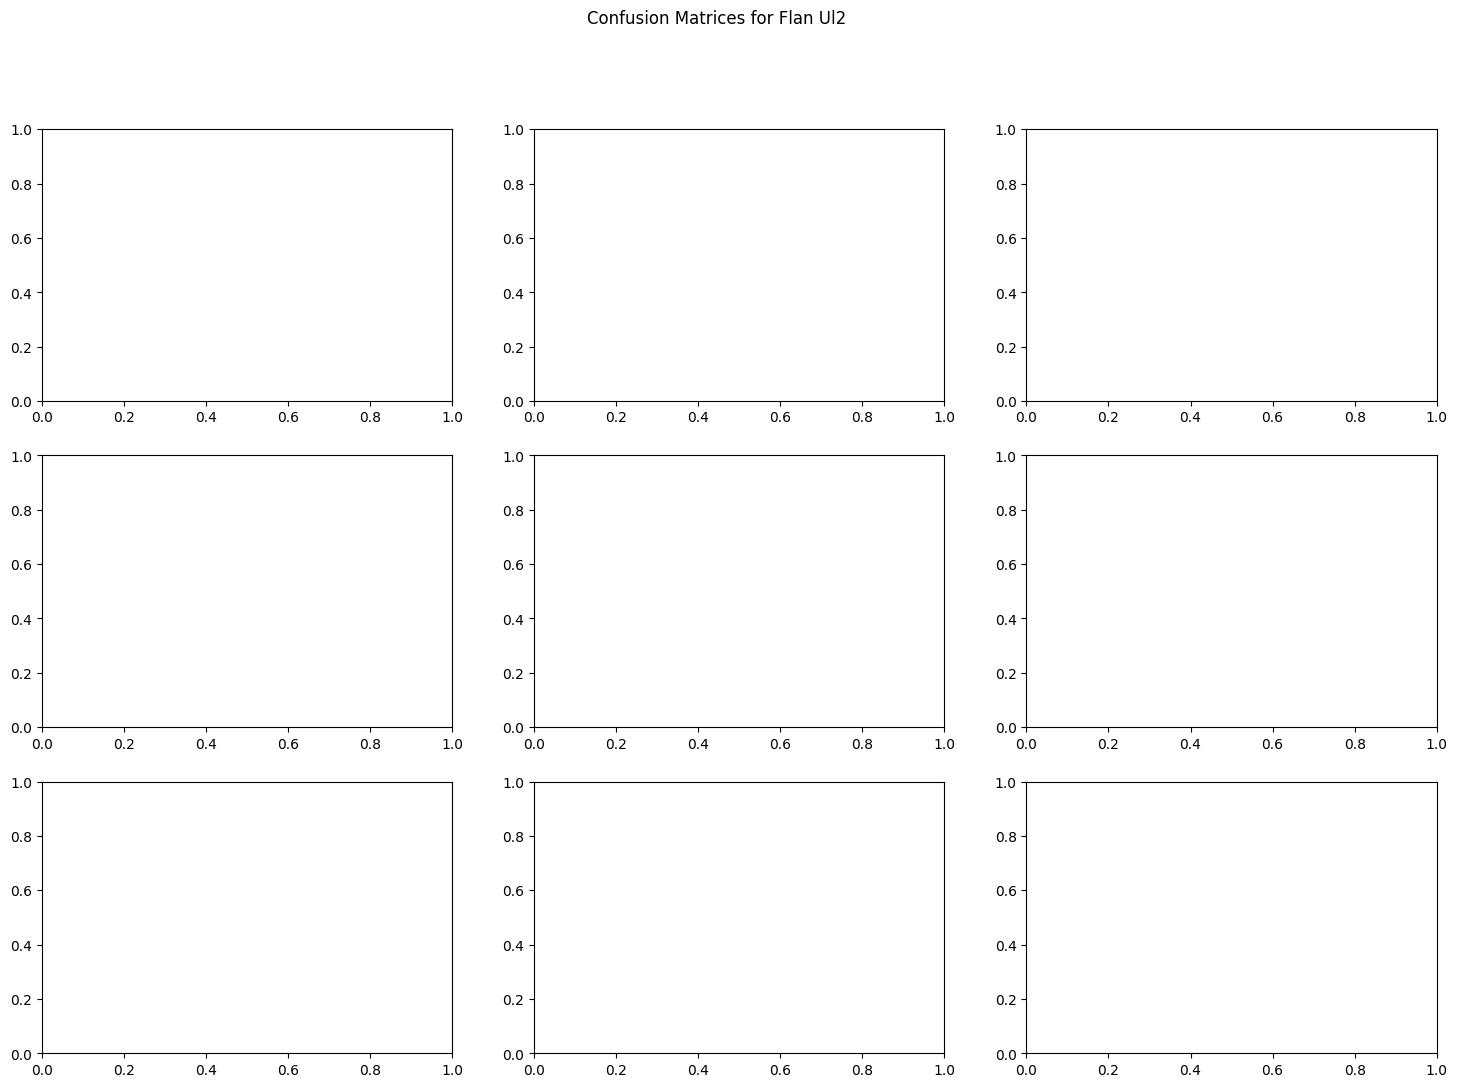

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(ax, df, true_labels_column, predicted_labels_column,
                          title=None
                          ):
    predicted_labels = df[f'{predicted_labels_column}']
    true_labels = df[f'{true_labels_column}']

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Display confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True,
                yticklabels=True, ax=ax)

    title = title if title else predicted_labels_column

    ax.set_title(f'Confusion Matrix - {title}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')


# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrices for Flan Ul2')

# Plot each confusion matrix
plot_confusion_matrix(axes[0, 0], df_merge, 'label', '0_shot_label', '0_shot')
plot_confusion_matrix(axes[0, 1], df_merge, 'label',
                      '0_shot_with_system_label', '0_shot_with_system')
plot_confusion_matrix(axes[0, 2], df_merge, 'label', '0_shot_cot_label',
                      '0_shot_cot')
plot_confusion_matrix(axes[1, 0], df_merge, 'label', '2_shot_label', '2_shot')
plot_confusion_matrix(axes[1, 1], df_merge, 'label', '4_shot_label', '4_shot')
plot_confusion_matrix(axes[1, 2], df_merge, 'label', '8_shot_label', '8_shot')
plot_confusion_matrix(axes[2, 0], df_merge, 'label', '2_shot_cot_label',
                      '2_shot_cot')
plot_confusion_matrix(axes[2, 1], df_merge, 'label', '4_shot_cot_label',
                        '4_shot_cot')
plot_confusion_matrix(axes[2, 2], df_merge, 'label', '8_shot_cot_label',
                        '8_shot_cot')

plt.tight_layout(
    rect=[0, 0, 1, 0.96])  # Adjust layout to prevent title overlap
plt.show()

# Krippendorff Alpha in model

In [ ]:
import krippendorff

runs = ['0_shot_label', '0_shot_with_system_label', '0_shot_cot_label',
        '2_shot_label', '4_shot_label', '8_shot_label', '2_shot_cot_label',
        '4_shot_cot_label', '8_shot_cot_label']


def compute_krippendorff_alpha(df, predicted_columns):
    pred_map = {}
    for run in predicted_columns:
        predicted_labels = df[run]
        pred_map[run] = predicted_labels

    # Check if there is variability in the ratings
    unique_labels_counts = df[predicted_columns].nunique(axis=1)
    if unique_labels_counts.max() == 1:
        # All ratings are the same, return a special value or handle accordingly
        return 0

    reliability_data = df[predicted_columns].values.tolist()

    # Calculate Krippendorff's alpha
    alpha = krippendorff.alpha(reliability_data=list(pred_map.values()),
                               level_of_measurement='nominal')

    return alpha


In [ ]:
alpha_value = compute_krippendorff_alpha(df_merge, runs)
print(f"Krippendorff's Alpha (all runs): {alpha_value}")

Krippendorff's Alpha (all runs): 0.541258823908169


In [ ]:
import itertools


def compute_krippendorff_alpha_for_k_runs(df, runs, k=None):
    # Initialize variables to store the best combination and alpha
    if k is None:
        k = len(runs)

    best_combination = None
    best_alpha = 0  # Assuming alpha ranges from 0 to 1

    # Iterate through all possible combinations
    for combination in itertools.combinations(runs, k):

        alpha_value = compute_krippendorff_alpha(df, list(combination))

        # Print alpha for the current combination
        print(f"Combination: {combination}, Alpha: {alpha_value}")

        # Update best combination and alpha if a higher alpha is found
        if alpha_value > best_alpha:
            best_alpha = alpha_value
            best_combination = combination

    # Print the best combination and alpha
    print(f"\nBest Combination: {best_combination}, Best Alpha: {best_alpha}")
    return best_alpha, best_combination

In [ ]:
compute_krippendorff_alpha_for_k_runs(df_merge, runs, 2)

Combination: ('0_shot_label', '0_shot_with_system_label'), Alpha: 0.6800546025273813
Combination: ('0_shot_label', '0_shot_cot_label'), Alpha: 0.45739210156460874
Combination: ('0_shot_label', '2_shot_label'), Alpha: 0.6901462383422312
Combination: ('0_shot_label', '4_shot_label'), Alpha: 0.6865671956267296
Combination: ('0_shot_label', '8_shot_label'), Alpha: 0.6831999684320494
Combination: ('0_shot_label', '2_shot_cot_label'), Alpha: 0.41418237349852316
Combination: ('0_shot_label', '4_shot_cot_label'), Alpha: 0.48012208059485617
Combination: ('0_shot_label', '8_shot_cot_label'), Alpha: 0.5182439616518166
Combination: ('0_shot_with_system_label', '0_shot_cot_label'), Alpha: 0.41379450461852507
Combination: ('0_shot_with_system_label', '2_shot_label'), Alpha: 0.6387792849250947
Combination: ('0_shot_with_system_label', '4_shot_label'), Alpha: 0.6634163220157041
Combination: ('0_shot_with_system_label', '8_shot_label'), Alpha: 0.7059018331700322
Combination: ('0_shot_with_system_label'

(0.7465937179719058, ('2_shot_label', '4_shot_label'))